<a href="https://colab.research.google.com/github/victorsergio/GNN-trajectory-prediction-2023/blob/main/sac_cluster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This script, create clusters of a defined area, for the intesection dataset.
# For clustering this script uses the diameter-clustering lib from https://github.com/antklen/diameter-clustering

In [ ]:
!pip install similaritymeasures
!pip install diameter-clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.7.0-py3-none-any.whl size=15453 sha256=ab3357ffeffbf2a2c0ad5323cedceecd34cdd21cded3d9e3aa74a05317f3cc54
  Stored in directory: /root/.cache/pip/wheels/15/9b/33/e21656ebf649d9ec5debb9914bf5928994cd1a10de01956901
Successfully built similaritymeasures
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diameter-clustering: filename=diameter_clustering-0.1.0-py3-none-any.whl size=15680 sha256=2a9388a7505e1b1963cb21c3420f029128e10dc82eeaa09f8de8f94d60d402ab
  Stored 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import similaritymeasures
from diameter_clustering import LeaderClustering
from diameter_clustering import MaxDiameterClustering

import math

In [ ]:


def read_data_from_file(file_name, split=1):
    
    train_file = file_name
    df = pd.read_csv(train_file, sep=',')

    # Select a percentage from full dataset (used in debugging)
    df = df.head(math.floor(df.shape[0]*split))


    return df


def filter_data(df):
    
    # Select cars only
    df = df.loc[df['agent_type'] == "car"]
    return df

def filter_length(df):            
     
    # Select only trajectories with the same length=40 and in the same time phase
 
    g = df.groupby(["case_id", "track_id"])
 
    g_equal_len = g.filter(lambda x: x['frame_id'].count() == 40. and (x['timestamp_ms'].ge(100).any() and x['timestamp_ms'].le(4000).any()))

    return g_equal_len


def compute_distance_matrix(trajectories):
    
    n = len(trajectories)
    dist_m = np.zeros((n, n))

    for i in range(n - 1):
        p = trajectories[i]
        p = p[:, [5, 6]]     # Use only x,y columns
        p = np.array(p, dtype=float)

        for j in range(i + 1, n):
            q = trajectories[j]
            q = q[:, [5, 6]] # Use only x,y columns
            q = np.array(q, dtype=float)

            dist_m[i, j] = similaritymeasures.frechet_dist(p, q)
            dist_m[j, i] = dist_m[i, j]
    return dist_m

def max_clustering(distance_matrix, max_radius):
    
    cl = MaxDiameterClustering(max_distance=max_radius,precomputed_dist=True, deterministic=True, sparse_dist=False)
    
    labels = cl.fit_predict(distance_matrix)  
    
    return labels

def show_seq_lengths(df):
  
    # Show the average length of sequences (40 frames)
    trajectories_len = []
    groups = df.groupby(["case_id", "track_id"])

    for name, group in groups:
        trajectories_len.append(len(group))

    sns.histplot(data=trajectories_len)

def cluster_trajectories(df, max_radius, sub_sampling=False):
    
    # Convert pandas dataframe to nested list 

    all_cases = []   #  Multi-dimensional list: ( n_cases, n_tracks, n_steps, n_features)

    case_groups = df.groupby(["case_id"])

    for name, group in case_groups:

        case_tracks = []

        tracks = group.groupby(["track_id"])
    
        for ix,seq in tracks:

            sub_seq = seq.to_numpy()
            # Code here for sub-sampling 5Hz
            if (sub_sampling == True):
                sub_seq = sub_seq[0::2,:]

            case_tracks.append(sub_seq)

        all_cases.append(case_tracks)

    
    clustered_trajectories = []

    # Group trajectories calculating distance matrix and using leader clustering

    for case_n in all_cases:

        distance_matrix = compute_distance_matrix(case_n)
        labels = max_clustering(distance_matrix, max_radius=max_radius)
    

        for index, traj in enumerate(case_n):

            label_column = np.full((case_n[index].shape[0]), labels[index])
               
            trajectory = np.insert(traj, case_n[index].shape[1], label_column, axis=1)  # Insert label column at last position
            clustered_trajectories.append(trajectory)

    return clustered_trajectories

def create_clustered_dataset(df, max_radius,split):  

    # Apply clustering to select only near cars
    clustering_result = np.array(cluster_trajectories(df,max_radius=max_radius,sub_sampling=True)) #50 mts
    clustering_result = clustering_result.reshape(-1,13) # Remove the dimension added by grouping by case. 13 is the number of features

    # Save results to new dataset file
    column_names = ['case_id', 'track_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width','label']
    clustered_df = pd.DataFrame(clustering_result,columns= column_names)    
    clustered_df.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/'+str(max_radius)+'m-DR_USA_Intersection_MA_'+split+'.csv',  index = False)

    return clustered_df
    


In [ ]:
# Read full dataset
df = read_data_from_file('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/DR_USA_Intersection_MA_train.csv', split=1.0)

In [ ]:
df.describe(include='all')

,case_id,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width
count,2.034258e+06,2.034258e+06,2.034258e+06,2.034258e+06,2034258,2.034258e+06,2.034258e+06,2.034258e+06,2.034258e+06,1.968886e+06,1.968886e+06,1.968886e+06
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1968886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.602180e+03,7.036720e+00,2.049817e+01,2.049817e+03,NaN,1.019636e+03,1.003383e+03,1.815930e+00,-5.261154e-02,-1.734498e-01,4.503169e+00,1.732801e+00
std,1.467484e+03,4.299566e+00,1.154278e+01,1.154278e+03,NaN,2.526298e+01,1.083934e+01,4.576061e+00,2.668814e+00,1.503246e+00,5.962974e-01,2.034712e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02,NaN,9.721870e+02,9.634890e+02,-1.570400e+01,-1.551600e+01,-3.142000e+00,2.660000e+00,1.350000e+00
25%,1.326000e+03,4.000000e+00,1.000000e+01,1.000000e+03,NaN,9.985190e+02,1.000341e+03,-7.300000e-02,-2.700000e-01,-1.426000e+00,4.230000e+00,1.560000e+00
50%,2.691000e+03,6.000000e+00,2.000000e+01,2.000000e+03,NaN,1.017082e+03,1.003935e+03,2.780000e-01,-1.600000e-02,-3.000000e-02,4.450000e+00,1.650000e+00
75%,3.938000e+03,1.000000e+01,3.000000e+01,3.000000e+03,NaN,1.034423e+03,1.007927e+03,3.659000e+00,3.590000e-01,1.940000e-01,4.680000e+00,1.910000e+00


In [ ]:
df.tail(50)

,case_id,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width
2034208,5163.0,1,31,3100,pedestrian/bicycle,1025.868,993.607,-3.353,-0.135,NaN,NaN,NaN
2034209,5163.0,2,31,3100,car,1033.764,989.498,0.056,1.148,1.522,4.41,1.51
2034210,5163.0,3,31,3100,car,1054.488,1003.788,10.943,0.584,0.053,4.55,1.62
2034211,5163.0,4,31,3100,car,1036.073,1001.258,10.089,0.176,0.017,4.47,1.74
2034212,5163.0,5,31,3100,car,1030.337,1007.714,-7.340,-0.064,-3.133,4.41,1.53
2034213,5163.0,1,32,3200,pedestrian/bicycle,1025.533,993.592,-3.343,-0.156,NaN,NaN,NaN
2034214,5163.0,2,32,3200,car,1033.752,989.613,0.044,1.282,1.536,4.41,1.51
2034215,5163.0,3,32,3200,car,1055.582,1003.855,10.973,0.656,0.060,4.55,1.62
2034216,5163.0,4,32,3200,car,1037.082,1001.277,10.179,0.186,0.018,4.47,1.74
2034217,5163.0,5,32,3200,car,1029.603,1007.709,-7.525,-0.057,-3.134,4.41,1.53


In [ ]:
# Select only vehicles
df = filter_data(df)

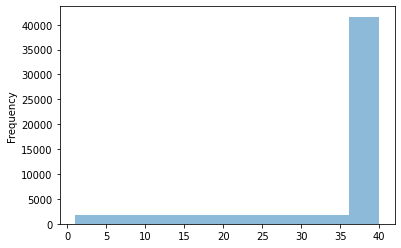

In [ ]:
# Show sequences' length
g = df.groupby(["case_id", "track_id"])
c = g.count()
column = c.frame_id
ax = column.plot.hist(bins=10, alpha=0.5)

# Select only same length sequences
df = filter_length(df)


# Full dataset info:
# 5163 episodes (cases)
# 60293 trajectories
# 2034258 rows
# 2 agent types

# Only cars dataset:

# 5163 episodes (cases)
# 58191 trajectories
# 1968886 rows
# 1 agent type

# length filtered dataset:
# 5163 episodes
# 40228 trajectories
# 1609120 rows
# 1 agent type

###############################


In [ ]:
df.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/Cars-Equal-Size-DR_USA_Intersection_MA_train.csv',  index = False)


In [ ]:
# Split in training and test set

from numpy.random import default_rng
import math


g = df.groupby(["case_id"])
g_count = g.ngroups

training_size = math.floor(g_count/100)*80 # 80% for the training size
test_size = g_count - training_size

rng = default_rng(1)
choice = rng.choice(g.ngroups, training_size, replace=False)


training = df[g.ngroup().isin(choice)]
test = df[~g.ngroup().isin(choice)]


In [ ]:
print("Full dataset size: ",g_count)

g = training.groupby(["case_id"])
g_count = g.ngroups
print("Training size:", g_count)

g = test.groupby(["case_id"])
g_count = g.ngroups
print("Test size:", g_count)

Full dataset size:  5163
Training size: 4080
Test size: 1083


In [ ]:
from time import process_time

# Create clustered dataset for training
start = process_time()
clustered_training = create_clustered_dataset(training, max_radius=50,split="train")
elapsed = (process_time() - start)


In [ ]:
print(elapsed)

190.10382052100002


In [ ]:
# Create clustered dataset for test
start = process_time()
clustered_test = create_clustered_dataset(test, max_radius=50,split="test")
elapsed = (process_time() - start)


In [ ]:
print(elapsed)

46.981192668999995


In [ ]:
# Load clustered dataset
clustered_df = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train.csv', sep=',')


max number of cars by cluster:  14


[Text(0, 0.5, 'number of groups'),
 Text(0.5, 0, 'number of interacting vehicles')]

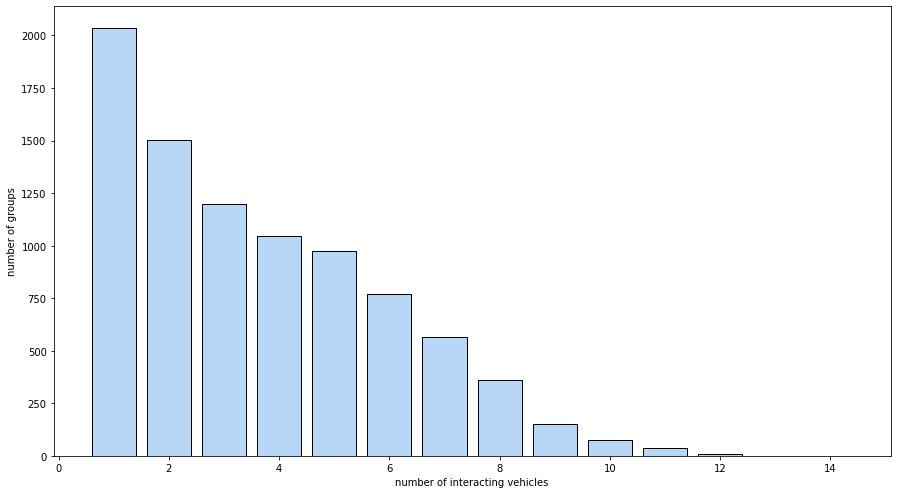

In [ ]:
# display parameters
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_palette("pastel")


# Display how many clusters were created, and its elements
case_id = clustered_df.groupby(["case_id", "label"])

g = []

for ix,element in case_id:
    l = element.groupby(["track_id"])
    g.append(len(l))

print("max number of cars by cluster: ", max(g)) 

ax = sns.histplot(ax=ax, data=g, discrete=True, shrink=.8)
ax.set(xlabel='number of interacting vehicles', ylabel='number of groups')

In [ ]:
# Load clustered dataset
clustered_df = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_test.csv', sep=',')


max number of cars by cluster:  14


[Text(0, 0.5, 'number of groups'),
 Text(0.5, 0, 'number of interacting vehicles')]

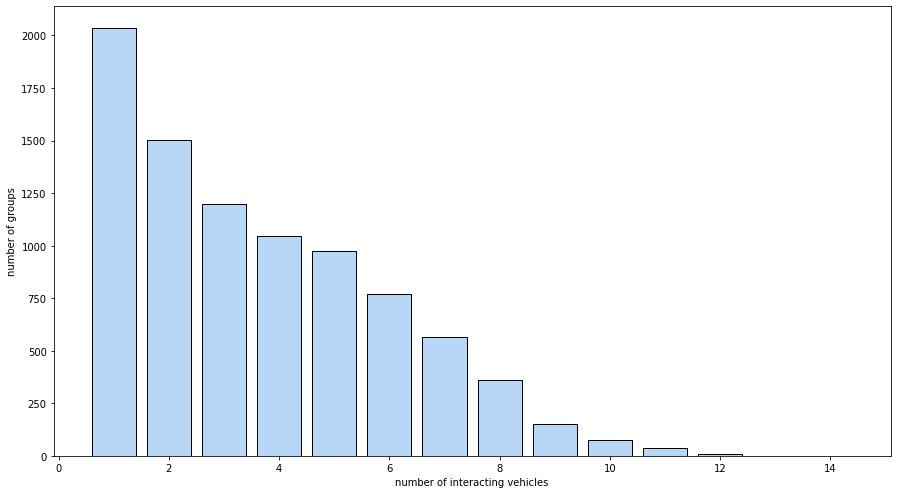

In [ ]:
# display parameters
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_palette("pastel")


# Display how many clusters were created, and its elements
case_id = clustered_df.groupby(["case_id", "label"])

g = []

for ix,element in case_id:
    l = element.groupby(["track_id"])
    g.append(len(l))

print("max number of cars by cluster: ", max(g))    
ax = sns.histplot(ax=ax, data=g, discrete=True, shrink=.8)
ax.set(xlabel='number of interacting vehicles', ylabel='number of groups')

In [ ]:
# Here is the end of orginal clustering code

In [ ]:
#@title
filtered = []

case_id = clustered_df.groupby(["case_id", "label"])

for ix,element in case_id:
    l = element.groupby(["track_id"])
    if(len(l)==5): # number of interacting vehicles
        for iy,e in l:
            filtered.append(e.values.tolist())
              

In [ ]:
#@title
# Convert list results to array
filtered_array = np.array(filtered)
filtered_array = filtered_array.reshape(-1,13) # Remove the dimension added by grouping by case. 13 is the number of features
# Create pandas dataframe from array
column_names = ['case_id', 'track_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width','label']
filtered_df = pd.DataFrame(filtered_array,columns= column_names)

# Save filtered dataset to file
filtered_df.to_csv('/content/drive/My Drive/PHD_2022/Latincom_2022/data-ablation/Filtered-100m-5cars-DR_USA_Intersection_MA_train.csv',  index = False)


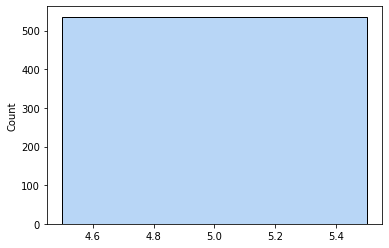

In [ ]:
#@title
case_id = filtered_df.groupby(["case_id", "label"])

g = []

for ix,element in case_id:
    l = element.groupby(["track_id"])
    g.append(len(l))

sns.histplot(data=g)

In [ ]:
#@title
print("number of groups of filtered vehicles: "+ str(len(g)))

number of groups of filtered vehicles: 536


In [ ]:
#@title
filtered_df.describe(include='all')

,case_id,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width,label
count,53600,53600,53600,53600,53600,53600,53600,53600,53600,53600,53600,53600,53600
unique,536,17,20,20,1,22954,14898,13277,8629,3729,176,78,2
top,2.0,5,1,100,car,1031.392,987.204,0.0,0.0,-0.029,4.25,1.6,0
freq,100,9200,2680,2680,53600,175,175,3264,3303,455,1380,3160,53200


In [ ]:
#@title
# 1226 groups of 5 cars each one
# 6130 trajectories
# 20 steps long each sequence
# 122600 rows

In [ ]:
#@title
# Load filtered dataset
filtered_df = pd.read_csv('/content/drive/My Drive/PHD_2022/Latincom_2022/data/Filtered-50m-5cars-DR_USA_Intersection_MA_train.csv', sep=',')

In [ ]:
#@title
filtered_df.head(50)

In [ ]:
#@title
case_id = filtered_df.groupby(["case_id", "label"])

for ix,element in case_id:
    l = element.groupby(["track_id"])
    print(len(l))

In [ ]:
#@title
# Label Intention


case_id = filtered_df.groupby(["case_id", "label"])

scenary_x = []
scenary_y = []
scenary_m = []



for ix,element in case_id:
    l = element.groupby(["track_id"])
    
    agents = [] # 5 trajectories (scenary), one per agent
    manuevers = []

    # Get 5 scenary trajectories
    for ig, eg in l:
        #feat = eg[["x", "y", "vx", "vy","psi_rad"]]
        feat = eg[["x", "y"]]

        ## 20x5
        discrete_manuever = eg['psi_rad'].diff().mean()
        manuevers.append(discrete_manuever)

        #if discrete_manuever <= 0.
        #manuevers_labels.append()
        
        
        f_list = feat.values.tolist()
        agents.append(f_list)
    
    # separate each trajectory
    a = np.array(agents[0])
    b = np.array(agents[1])
    c = np.array(agents[2])
    d = np.array(agents[3])
    e = np.array(agents[4])

    # separate manuevers

    a_m = np.array(manuevers[0])
    b_m = np.array(manuevers[1])
    c_m = np.array(manuevers[2])
    d_m = np.array(manuevers[3])
    e_m = np.array(manuevers[4])



    # split
    #a_x = a[0:10,:]
    #a_y = a[10:,:] 

    #b_x = b[0:10,:]
    #b_y = b[10:,:] 
    
    #c_x = c[0:10,:]
    #c_y = c[10:,:] 

    #d_x = d[0:10,:]
    #d_y = d[10:,:] 

    #e_x = e[0:10,:]
    #e_y = e[10:,:] 
    


    #d_x = np.hstack((a_x,b_x,c_x,d_x,e_x))
    d_x = np.hstack((a,b,c,d,e))
    d_x = d_x.reshape(20,5,2) # timesteps, ncars, 5 features

    m_y = np.hstack((a_m,b_m,c_m,d_m,e_m))
    m_y = m_y.reshape(1,5,1) 
    

    #d_y = np.hstack((a_y,b_y,c_y,d_y,e_y))
    #d_y = d_y.reshape(10,5,5) # timestesp, ncars, 2 features (because we only predict the future x,y)



    scenary_x.append(d_x)
    #scenary_y.append(d_y)
    scenary_m.append(m_y)
        
    
s1 = np.array(scenary_x)   
print(s1.shape)

s3 = np.array(scenary_m)   
print(s3.shape)


#s2 = np.array(scenary_y)   
#print(s2.shape)

(1226, 20, 5, 2)
(1226, 1, 5, 1)


In [ ]:
#@title
print(s1[0])

[[[1001.625 1000.479]
  [1007.829 1003.295]
  [1023.811 1005.446]
  [1030.456  986.293]
  [1014.956 1030.461]]

 [[1002.435 1000.45 ]
  [1009.081 1003.232]
  [1024.803 1004.862]
  [1030.454  986.316]
  [1015.237 1028.705]]

 [[1003.348 1000.413]
  [1010.399 1003.178]
  [1025.85  1004.352]
  [1030.45   986.348]
  [1015.508 1027.003]]

 [[1004.362 1000.371]
  [1011.781 1003.137]
  [1026.955 1003.913]
  [1030.444  986.4  ]
  [1015.766 1025.375]]

 [[1005.473 1000.325]
  [1013.228 1003.107]
  [1028.12  1003.542]
  [1030.435  986.476]
  [1016.01  1023.84 ]]

 [[1006.68  1000.277]
  [1014.74  1003.091]
  [1029.35  1003.234]
  [1030.423  986.585]
  [1016.237 1022.411]]

 [[1007.977 1000.229]
  [1016.317 1003.086]
  [1030.65  1002.983]
  [1030.407  986.732]
  [1016.446 1021.1  ]]

 [[1009.359 1000.185]
  [1017.96  1003.093]
  [1032.023 1002.781]
  [1030.386  986.923]
  [1016.639 1019.912]]

 [[1010.82  1000.147]
  [1019.667 1003.111]
  [1033.47  1002.622]
  [1030.361  987.157]
  [1016.814 1018

In [ ]:
#@title
manuevers_values = s3.flatten()  # a flatten vector with all the yaw average rate

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


(0.0, 0.02)

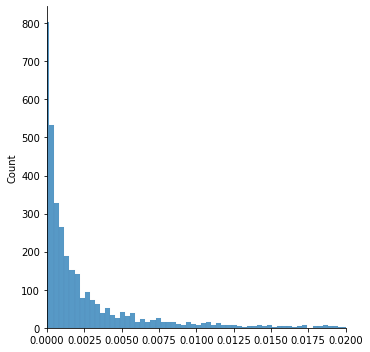

In [ ]:
#@title

sns.displot(manuevers_values, ax=ax)
plt.ylim(0, None)
plt.xlim(0, 0.02)



In [ ]:
#@title
import tensorflow as tf
import matplotlib.pyplot as plt

# Display single trajectories

def print_single_trajectory(scene,n, ix):
    
    #prev = prev_list[ix:ix+n]

    scene = tf.transpose(scene,[1,0,2])
    
   
    fig, ax = plt.subplots(1,5,figsize=(20,4))


    #t = scene[2]

    for i,t in enumerate(scene):
 
        for j,p in enumerate(t):
        
        
        #p = tf.transpose(p,[1,0]) 
            if(j == 0):
                ax[i].plot(p[0], p[1],'-o',color='red',linestyle='dashed')
                ax[i].set_aspect('equal', adjustable='datalim')  
            else:
                ax[i].plot(p[0], p[1],'-o',color='gray',linestyle='dashed')
                ax[i].set_aspect('equal', adjustable='datalim')
        
        
    
    plt.show()

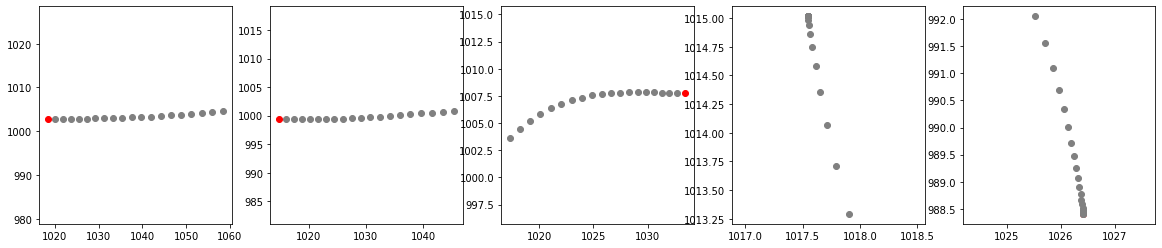

[[[ 0.00610526]
  [ 0.00631579]
  [-0.29121053]
  [ 0.00442105]
  [ 0.00952632]]]


In [ ]:
#@title
print_single_trajectory(s1[25],5,1)
print(s3[25])

In [ ]:
#@title
# negative number rigth turn
# positive number left turn
# almost 0, small negative or small positive number, straigth

In [ ]:
#@title
s1.shape

(1226, 20, 5, 2)

In [ ]:
#@title
print(s3[0][0][0])

[0.00284211]


In [ ]:
#@title
print(s3[0])

[[[0.00284211]
  [0.00489474]
  [0.03552632]
  [0.00026316]
  [0.00194737]]]


[[4.71445890e-02 6.35234652e-01]
 [9.60961273e-01 8.43112858e-01]
 [8.69118986e-01 4.40481274e-01]
 [1.43815516e-01 8.69355047e-01]
 [7.35051316e-01 5.95254851e-01]
 [1.85282825e-01 7.46716949e-01]
 [2.74941606e-01 8.77495803e-02]
 [7.52593622e-01 1.84220524e-01]
 [8.30913842e-01 4.05740498e-01]
 [8.58789322e-01 2.77068672e-01]
 [5.99411125e-01 3.10899600e-01]
 [5.76755035e-01 7.13428093e-01]
 [2.61916794e-01 8.01261341e-04]
 [5.53477363e-01 1.53674342e-02]
 [7.67210973e-01 3.16307684e-01]
 [1.05878727e-01 8.23054945e-01]
 [4.73951286e-01 1.39218772e-01]
 [6.16154892e-01 5.18564646e-01]
 [1.23631925e-01 3.47177839e-01]
 [7.12539155e-01 7.56264340e-01]
 [9.03072949e-01 2.03437121e-01]
 [3.06746672e-02 6.02434304e-01]
 [6.40270564e-01 4.12765643e-01]
 [3.88092369e-01 6.36092854e-01]
 [3.30169123e-01 9.42254296e-01]
 [2.82079226e-01 3.14851276e-01]
 [7.53942678e-01 9.76815826e-01]
 [4.45063657e-01 9.74353578e-01]
 [6.34606006e-01 6.30853264e-02]
 [2.02687047e-01 9.62537691e-01]
 [3.486550

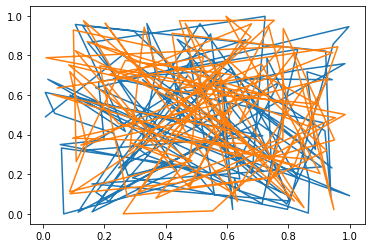

In [ ]:
#@title
import numpy as np
import similaritymeasures
import matplotlib.pyplot as plt

# Generate random experimental data
x = np.random.random(100)
y = np.random.random(100)
exp_data = np.zeros((100, 2))
exp_data[:, 0] = x
exp_data[:, 1] = y

# Generate random numerical data
x = np.random.random(100)
y = np.random.random(100)
num_data = np.zeros((100, 2))
num_data[:, 0] = x
num_data[:, 1] = y

print (num_data)
# quantify the difference between the two curves using
# Discrete Frechet distance
df = similaritymeasures.frechet_dist(exp_data, num_data)



# print the results
print(df.dtype)

# plot the data
plt.figure()
plt.plot(exp_data[:, 0], exp_data[:, 1])
plt.plot(num_data[:, 0], num_data[:, 1])
plt.show()